In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import json
from ipymarkup import show_span_box_markup

In [2]:
SEED = 2024*5
random.seed(SEED)
np.random.seed(SEED)

# Загрузка данных

In [3]:
with open("../data/share/train.json", encoding="utf-8") as f:
    data = json.load(f)
print("Dataset size:", len(data), "\n")
data[:2]

Dataset size: 330 



[{'text': '**Когда квитанция поступит,** вАрхиве поступлений в «Статусе маркировки» отобразится статус по накладной «Продажа разрешена» или «Принято с расхождениями».  \n  \nПринятые марки добавятся на остатки магазина, **товары станут доступны для продажи на кассе**.\n* **Принято с расхождениями** – марки приняты НЕ ПО ВСЕМ товарам.  \n  \nНеобходимо провалиться в документ поступления и проверить статус маркировки по каждой +7 010 618 1753.',
  'entities': [{'entity_group': 'TELEPHONE',
    'word': '+7 010 618 1753',
    'start': 413,
    'end': 428}]},
 {'text': '**Контакты ответственных менеджеров по MVU и KIT каждой территории:**\n\n\n\n|  |  |  |\n| --- | --- | --- |\n| **Территория** | **ФИО менеджера** | **Эл. почта** |\n| Волга | Елисеева Олимпиада Максимовна | ribakovapolina@zao.info |\n| Восток | Колесников Селиверст Харламович | erofesafonov@boes.info |\n| Северо-Запад | Григорьев Зиновий Александрович | fdoronin@tsvetkova.com |\n| Центр | Агафон Егорович Селиверстов | klavd

In [4]:
data[72]
# Ошибка в разметке ?: конец одного номера телефона перекрывает начало другого

{'text': '**Условия:*** Товар по регулярной цене – минус98.16% от цены ценника;\n* Товар по акционной цене – акционная цена;\n* Товар со скидкой по+7 010 6+7 010 618 1753 (ВК) – акционная цена (если OJE отсканирована в чек) или минус98.16% от регулярной цены (если OJE не отсканирована);\n* RMV работает без ограничения по времени суток и дню недели;\n* Для получения скидки, необходимо показать кассиру RMV на своем мобильном телефоне (классические кассы РКУ), или самостоятельно отсканировать RMV в чек (для касс самообслуживания КСО).',
 'entities': [{'entity_group': 'PERCENT',
   'word': '98.16%',
   'start': 46,
   'end': 52},
  {'entity_group': 'TELEPHONE',
   'word': '+7 010 618 1753',
   'start': 135,
   'end': 150},
  {'entity_group': 'TELEPHONE',
   'word': '+7 010 618 1753',
   'start': 143,
   'end': 158},
  {'entity_group': 'ACRONYM', 'word': 'OJE', 'start': 186, 'end': 191},
  {'entity_group': 'PERCENT', 'word': '98.16%', 'start': 221, 'end': 227},
  {'entity_group': 'ACRONYM',

In [5]:
data[226]
# Есть неразмеченный номер телефона
# У текста временами отсутствует какой-либо смысл. Такое впечатление, что сущности вставлялись рандомным образом в текст
# Возможно оригинальные именованные сущности были обезличены

{'text': '+7 010 618 1753 закрывается или переезжает?  Не получается зайти в ZPD и OZP? Не получается принять посылку? Что делать и кому звонить ты узнаешь из памяток в этом разделе.   \n  \n**НЕТ ПЛОМБ** **– создай инцидент в ZPD с типом «Нет пломбы для возврата»!**\n\nПо неотложным вопросам работает XUY Ферронордик машины (Ferronordic) **+7(800)505-41-81**\n\nОбучающие видеоролики, можно запросить у менеджера по операциям Ферронордик машины (Ferronordic) через QBH. \n\nКонтакты менеджеров доступны по ссылке.',
 'entities': [{'entity_group': 'TELEPHONE',
   'word': '+7 010 618 1753',
   'start': 0,
   'end': 15},
  {'entity_group': 'ACRONYM', 'word': 'ZPD', 'start': 66, 'end': 71},
  {'entity_group': 'TECH', 'word': 'OZP', 'start': 73, 'end': 76},
  {'entity_group': 'ACRONYM', 'word': 'ZPD', 'start': 214, 'end': 219},
  {'entity_group': 'ACRONYM', 'word': 'XUY', 'start': 288, 'end': 293},
  {'entity_group': 'ORG',
   'word': 'Ферронордик машины (Ferronordic)',
   'start': 293,
   'end

In [6]:
data[226]["text"][0:15], data[226]["text"][66:71], data[226]["text"][73:76], data[226]["text"][293:325], data[226]["text"][451:454]
# Некоторые акронимы длинною в 3 символа помечены как 5 символов (пробелы по бокам)

('+7 010 618 1753', ' ZPD ', 'OZP', 'Ферронордик машины (Ferronordic)', 'QBH')

Можно заметить, что есть ошибки в разметке, а также не всегда именнованная сущность находится в правильном контексте. \
Также: номера телефонов почти все одинаковые \
Номера телефонов состоят из нескольких токенов \
Имена состоят из нескольких токенов, впрочем как и некоторые другие сущности. Лучше использовать BIO разметку

# Визуализация именованных сущностей и распределения меток классов

In [7]:
texts = []
spans = []
for sample in data:
    texts.append(sample["text"])
    current_spans = []
    for entity in sample["entities"]:
        current_spans.append((entity["start"], entity["end"], entity["entity_group"]))
    spans.append(current_spans)
show_n = 10
for i, text, span in zip(range(show_n), texts[:show_n], spans[:show_n]):
    print(f"-------- TEXT: {i + 1} --------")
    show_span_box_markup(text, span)

-------- TEXT: 1 --------


-------- TEXT: 2 --------


-------- TEXT: 3 --------


-------- TEXT: 4 --------


-------- TEXT: 5 --------


-------- TEXT: 6 --------


-------- TEXT: 7 --------


-------- TEXT: 8 --------


-------- TEXT: 9 --------


-------- TEXT: 10 --------


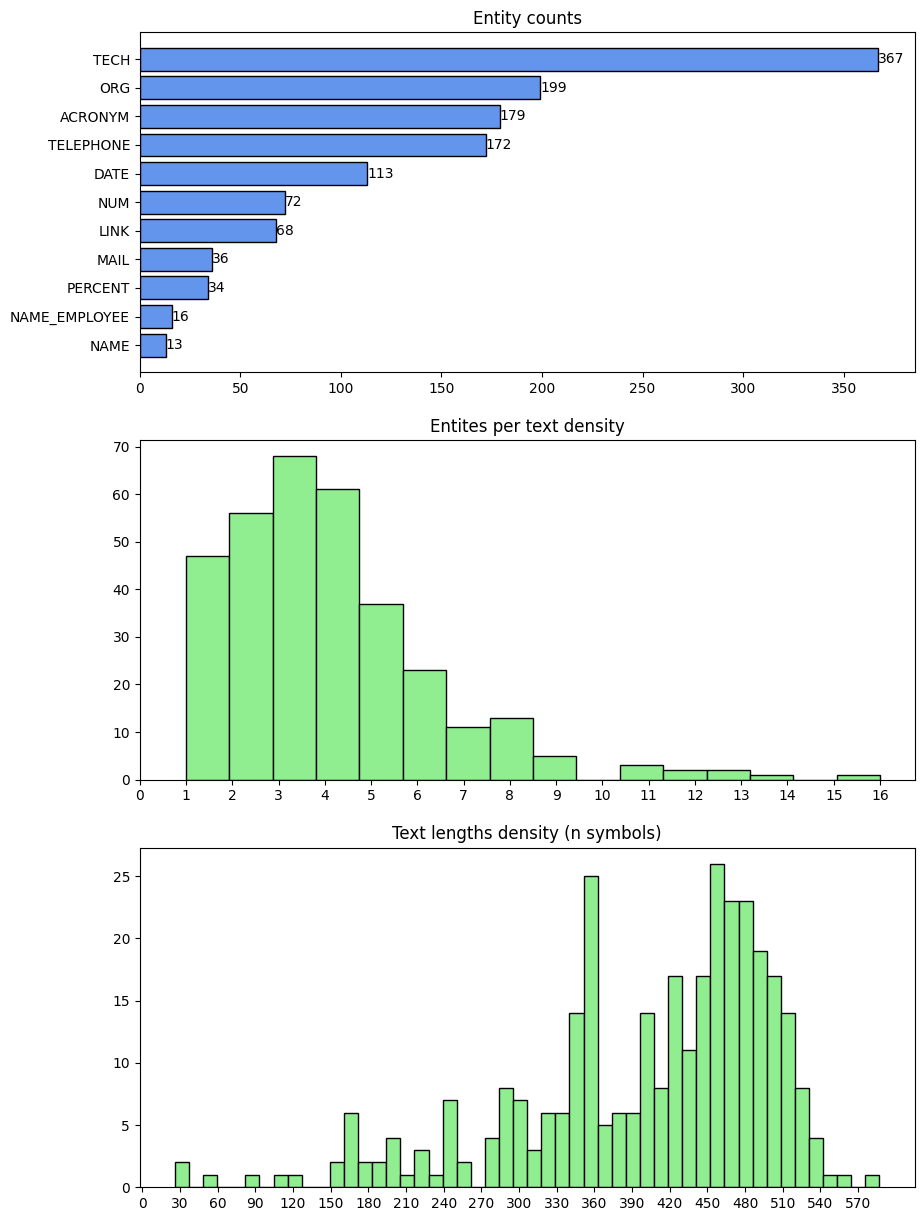

In [8]:
entities = {}
text_lens = []
entities_per_text = []
for sample in data:
    text_lens.append(len(sample["text"]))
    entities_per_text.append(len(sample["entities"]))
    for entity in sample["entities"]:
        if entity['entity_group'] not in entities.keys():
            entities[entity['entity_group']] = 0
        entities[entity['entity_group']] += 1
entities = {k: v for k, v in sorted(entities.items(), key=lambda item: item[1])}

fig, ax = plt.subplots(3, figsize=(10, 15))
bars = ax[0].barh(entities.keys(), entities.values(), color="cornflowerblue", ec='black')
ax[0].bar_label(bars)
ax[0].set_title("Entity counts")

ax[1].hist(entities_per_text, color='lightgreen', ec='black', bins=np.max(entities_per_text))
ax[1].set_title("Entites per text density")
ax[1].xaxis.set_ticks(np.arange(0, max(entities_per_text) + 1))

ax[2].hist(text_lens, color='lightgreen', ec='black', bins=50)
ax[2].set_title("Text lengths density (n symbols)")
ax[2].xaxis.set_ticks(np.arange(0, max(text_lens) + 1, step=30))
plt.show()

In [9]:
with open("../data_processed/entity_names.txt", "w", encoding="utf8") as f:
    for i, entity in enumerate(entities.keys()):
        if i + 1 != len(entities.keys()):
            f.write(f"{entity} ")
        else:
            f.write(f"{entity}")

# Просмотр примеров именованных сущностей

In [10]:
entity_examples = {}
for sample in data:
    for entity in sample["entities"]:
        if entity['entity_group'] not in entity_examples.keys():
            entity_examples[entity['entity_group']] = []
        entity_examples[entity['entity_group']].append(entity['word'])

In [11]:
for example_name, example_vals in entity_examples.items():
    print(f"{example_name}:")
    print(example_vals[:10], "\n")

TELEPHONE:
['+7 010 618 1753', '+7 010 618 1753', '+7 010 618 1753', '+7 010 618 1753', '+7 010 618 1753', '+7 010 618 1753', '+7 010 618 1753', '+7 010 618 1753', '+7 010 618 1753', '+7 010 618 1753'] 

ACRONYM:
['MVU', 'KIT', 'VLF', 'WNQ', 'WNQ', 'YLJ', 'RMV', 'RMV', 'YLJ', 'WRL'] 

NAME:
['Елисеева Олимпиада Максимовна', 'Колесников Селиверст Харламович', 'Григорьев Зиновий Александрович', 'Агафон Егорович Селиверстов', 'Егор Гертрудович Голубев', 'Пестов Порфирий Эдгардович', 'Князева Оксана Ефимовна', 'Андроник Тарасович Молчанов', 'Юлий Алексеевич Галкин', 'Гуляев Самсон Венедиктович'] 

MAIL:
['ribakovapolina@zao.info', 'erofesafonov@boes.info', 'fdoronin@tsvetkova.com', 'klavdi_2003@nesterova.ru', 'kulikovapollon@novosibirskenergosbit.ru', 'krasilnikovamos@gruppa.edu', 'potap64@npo.biz', 'potap64@npo.biz', 'potap64@npo.biz', 'julian99@kazakov.org'] 

LINK:
['http://rao.org/', 'https://www.potapova.org/', 'https://www.potapova.org/', 'http://ao.net/', 'https://obedinennaja.biz/'

Можно заметить, что некоторые сущности не очень разнообразны по своим возможным значениям:

In [12]:
counts = {}
for example_name, example_vals in entity_examples.items():

    current_counts = {}
    for ex_val in example_vals:
        if ex_val not in current_counts.keys():
            current_counts[ex_val] = 0
        
        current_counts[ex_val] +=1

    current_counts = {k: v for k, v in sorted(current_counts.items(), key=lambda item: item[1], reverse=True)}
    counts[example_name] = current_counts

for key, count_dict in counts.items():
    print(f"---{key}---")
    print(f"{len(count_dict)} unique samples:")
    print(count_dict)
    print()



---TELEPHONE---
7 unique samples:
{'+7 010 618 1753': 166, '+7 192 927 5243': 1, '8 (280) 512-92-76': 1, '8 372 395 04 10': 1, '+7 281 442 94 44': 1, '+7 (767) 478-36-67': 1, '+72860476580': 1}

---ACRONYM---
59 unique samples:
{'RMV': 25, 'HMN': 15, 'ZSQ': 15, 'WNQ': 6, 'WRL': 6, 'QHJ': 6, 'YTM': 6, 'CYU': 5, 'MDW': 5, 'KIT': 4, 'VLP': 4, 'VBX': 4, 'FNG': 4, 'EOL': 4, 'TSJ': 4, 'MVU': 3, 'YLJ': 3, 'SUK': 3, 'TBQ': 3, 'RKT': 3, 'VLF': 2, 'MUW': 2, 'QRM': 2, 'CFV': 2, 'NTU': 2, 'OJE': 2, 'NWN': 2, 'HNV': 2, 'GUU': 2, 'ZPD': 2, 'MGL': 2, 'WXL': 2, 'GMX': 1, 'VJZ': 1, 'UQK': 1, 'QJG': 1, 'RDJ': 1, 'HMU': 1, 'UIG': 1, 'QQU': 1, 'SOG': 1, 'NDE': 1, 'KBY': 1, 'IZG': 1, 'KPR': 1, 'QGN': 1, 'CQL': 1, 'COL': 1, 'GZD': 1, 'MTT': 1, 'EOX': 1, 'PNQ': 1, 'TFS': 1, 'XUY': 1, 'RFK': 1, 'GKD': 1, 'BDA': 1, 'CZV': 1, 'HZT': 1}

---NAME---
12 unique samples:
{'Гуляев Самсон Венедиктович': 2, 'Елисеева Олимпиада Максимовна': 1, 'Колесников Селиверст Харламович': 1, 'Григорьев Зиновий Александрович': 1, '